In [43]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
from scipy.special import gammaln
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from joblib import Parallel, delayed

# Import custom libraries
import utils as lu
import large_average_submatrix_hic_avgcutoff_iter as las
reload(lu)
reload(las)

<module 'large_average_submatrix_hic_avgcutoff_iter' from '/home/louiscam/projects/gpcr/code/analysis_LAS/large_average_submatrix_hic_avgcutoff_iter.py'>

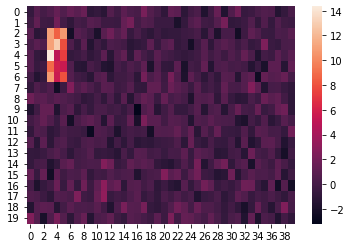

In [62]:
# Simulate data
seed = 13
data = las.simulate_data(seed)
m, n = data.shape
data = pd.DataFrame(data, index=np.arange(m), columns=np.arange(n).astype(str))
plt.figure()
sns.heatmap(data)
plt.show()

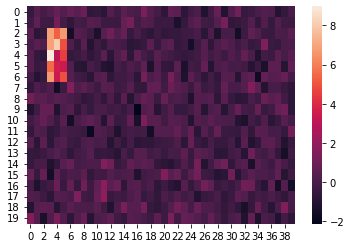

In [63]:
# Transform the data
mean = data.values.flatten().mean()
std = data.values.flatten().std()
zscored_data = (data-mean)/std
plt.figure()
sns.heatmap(zscored_data)
plt.show()

In [64]:
# LAS parameters
iters = 100
max_submatrix_size = 10
alpha = 0.01

# Count the number of submatrices of size max_submatrix_size
n_hyp = 0
for k,l in itertools.product(range(max_submatrix_size), range(max_submatrix_size)):
    n_hyp = n_hyp+(n-k+1)*(m-l+1)
pvalue_threshold = 1-alpha/n_hyp
threshold_stat = ss.norm.ppf(pvalue_threshold)
print(f'Total number of hypotheses = {n_hyp}')
print(f'Bonferroni p-value threshold = {pvalue_threshold}')
print(f'Bonferroni statistic threshold = {threshold_stat}')

Total number of hypotheses = 60225
Bonferroni p-value threshold = 0.9999998339559983
Bonferroni statistic threshold = 5.104261953603367


In [65]:
# LAS algorithm

def search(data, max_submatrix_size):
    # run search procedure with fixed k, l first
    max_num_rows = int(max_submatrix_size/1)
    max_num_cols = int(max_submatrix_size/1)
    k = random.randint(1, max_num_rows)
    l = random.randint(1, max_num_cols)
    row_set, col_set = las.search_fixed_k_l(data, k,l)

    # allow k and l to vary
    # initialize the running average
    pre_score = -1000000
    curr_score = 0
    # iterate until convergence
    while(pre_score != curr_score):
        # sum across columns
        row_summed = np.sum(col_set, axis =1)
        start_row, k, score_rows = las.enumerate_adj_submatrix_scores(data, row_summed, max_num_rows, k, l, 'row')
        # make a row set
        row_set = data[start_row:start_row+k, :]

        # columns
        col_summed = np.sum(row_set, axis =0)
        start_col, l, score_cols = las.enumerate_adj_submatrix_scores(data, col_summed, max_num_cols, k, l, 'col')
        # make a col set
        col_set = data[:,start_col:start_col+l]

        # update scores
        pre_score = curr_score
        curr_score = score_cols
        #print('Score = ', pre_score, curr_score)

    return start_row, k, start_col, l, curr_score

def search_main(data, dir, iter, max_submatrix_size, iters):
    num_iter = iters
    # keep track of submatrix params that you get out
    search_attributes = np.empty((num_iter, 5))
    for iteration in range(num_iter):
        start_row, k, start_col, l, curr_score = search(data, max_submatrix_size)
        search_attributes[iteration] = start_row, k, start_col,l ,curr_score

    # save the iterations
    np.savetxt(dir + 'sub_matrix' + str(iter) + '.txt', search_attributes)


    best_start_row, best_k, best_start_col, best_l, best_score =  search_attributes[np.argmax(search_attributes[:,4])]
    rows = np.arange(best_start_row, best_start_row + best_k, dtype = 'int')
    cols = np.arange(best_start_col, best_start_col + best_l, dtype = 'int')
    sub_matrix = data[np.ix_(rows,cols)]
    return rows, cols, sub_matrix, best_score

def large_average_submatrix_adj(data, threshold_stat, max_submatrix_size, iters):
    # store some data on iterations
    dir = '/home/louiscam/projects/gpcr/code/analysis_LAS/LAS_test/'
    if (os.path.isdir(dir) == False):
        os.makedirs(dir)

    # algorithm until score falls below threshold
    continue_search = True
    iter = 0
    # store matrices
    start_rows, stop_rows, start_cols, stop_cols, best_score_list, avg_list = [], [], [], [], [], []

    while (continue_search):
        rows, cols, sub_matrix, best_score = search_main(data, dir, iter, max_submatrix_size, iters)
        data = las.residual(sub_matrix, data, rows, cols)
        # check whether score is below threshold based on the the size of submatrix
        continue_search = las.check_submatrix_below_threshold(sub_matrix, threshold_stat)
        if (continue_search == True):
            start_rows.append(rows[0])
            stop_rows.append(rows[-1])
            start_cols.append(cols[0])
            stop_cols.append(cols[-1])
            best_score_list.append(best_score)
            avg_list.append(np.average(sub_matrix))
            iter = iter + 1
            print('Best score = ', best_score)
            print('Average = ', np.average(sub_matrix))
            print(rows[0], rows[-1], cols[0], cols[-1])

    return start_rows, stop_rows, start_cols, stop_cols, best_score_list, avg_list

def run_LAS(df, threshold_stat, max_submatrix_size, iters):
    
    # Load data
    data = df.values

    # run LAS algorithm
    start_rows, stop_rows, start_cols, stop_cols, best_score_list, avg_list = large_average_submatrix_adj(
        data, threshold_stat, max_submatrix_size, iters
    )

    # convert indices to positions
    start_row_pos, stop_row_pos, start_col_pos, stop_col_pos = las.map_num2pos(df, start_rows, stop_rows, start_cols, stop_cols)

    # store results in dataframe
    dic = {'start row' : pd.Series(start_row_pos), 'stop row' : pd.Series(stop_row_pos), 'start col' : pd.Series(start_col_pos), 'stop col': pd.Series(stop_col_pos), 'score' : pd.Series(best_score_list), 'avg' : pd.Series(avg_list)}
    df_intermingling = pd.DataFrame(dic, columns=dic.keys())
    
    return(df_intermingling)

In [66]:
# Run LAS
out_df = run_LAS(zscored_data, threshold_stat, 5, iters)

21.29493418837101 5.104261953603367
Best score =  224.30653707765293
Average =  5.498328364676258
2 6 3 5
3.576680996168068 5.104261953603367


In [67]:
# Show list of intermingling regions
out_df

,start row,stop row,start col,stop col,score,avg
0,2,6,3.0,5.0,224.306537,5.498328


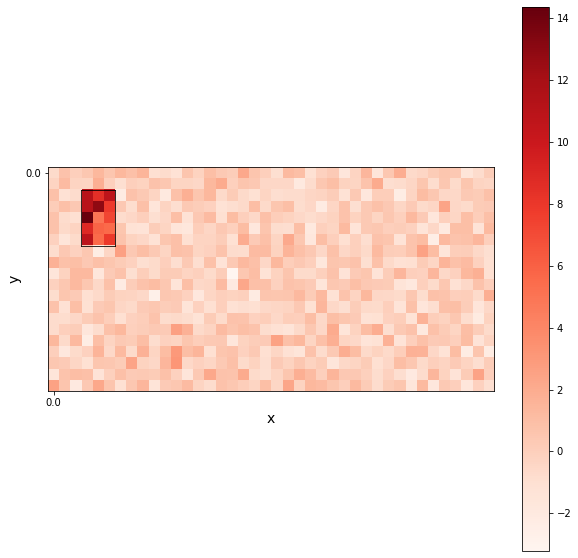

In [68]:
# Plot identified LAS regions
minl, maxl = data.min().min(), data.max().max()

plt.figure(figsize=(10,10))
plt.imshow(data.values, cmap = 'Reds', vmin = minl, vmax = maxl)
cbar = plt.colorbar()
cbar.solids.set_rasterized(True) 

# label ticks with genomic position (Mb)
xaxis = range(0, data.shape[1], 100)
xlabels = [str(las.map_colnum2pos(data, x)/1) for x in xaxis]
plt.xticks(xaxis, xlabels)
yaxis = range(0, data.shape[0], 100)
ylabels = [str(las.map_rownum2pos(data, y)/1) for y in yaxis]
plt.yticks(yaxis, ylabels)

plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)

df_intermingling = out_df.copy()
# iterate over all las regions found
for num in range(0, len(df_intermingling)):
    region = df_intermingling.iloc[num]
    start_row = region['start row']-0.5
    stop_row = region['stop row']+0.5
    start_col = region['start col']-0.5
    stop_col = region['stop col']+0.5

    # draw vertical lines - columns are same
    plt.plot([start_col, start_col], [start_row, stop_row], 'k-', lw = 0.8)
    plt.plot([stop_col, stop_col], [start_row, stop_row], 'k-', lw = 0.8)
    # draw horizontal lines - rows are same
    plt.plot([start_col, stop_col], [start_row, start_row], 'k-', lw = 0.8)
    plt.plot([start_col, stop_col], [stop_row, stop_row], 'k-', lw = 0.8)

plt.show()